In [1]:
from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%pwd

'/home/qiao/dev/giao/havingfun/detecting/segmentation/unet34'

In [3]:
print(torch.cuda.is_available())

True


In [4]:
path = Path('/home/qiao/dev/giao/datasets/M300bounding/20220613')

path_img = path/'imgs/'
path_label = path/'labels'
codes = ['Smoke', 'Flame', 'Background']
path_img

Path('/home/qiao/dev/giao/datasets/M300bounding/20220613/imgs')

In [5]:
fnames = get_image_files(path_img)
print(fnames[0])

/home/qiao/dev/giao/datasets/M300bounding/20220613/imgs/M300_20220613_41.2_13.png


In [6]:
lbl_names = get_image_files(path_label)
print(lbl_names[0])

/home/qiao/dev/giao/datasets/M300bounding/20220613/labels/label_M300_20220613_41.2_31.png


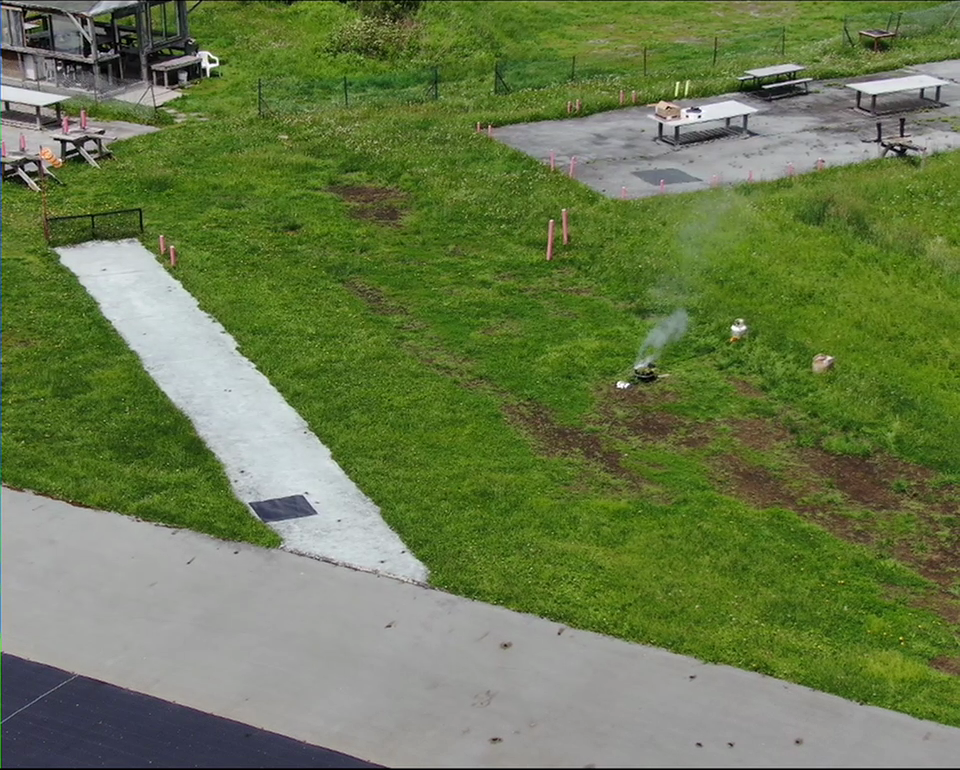

In [7]:
img = Image.open(fnames[0])
img.show()

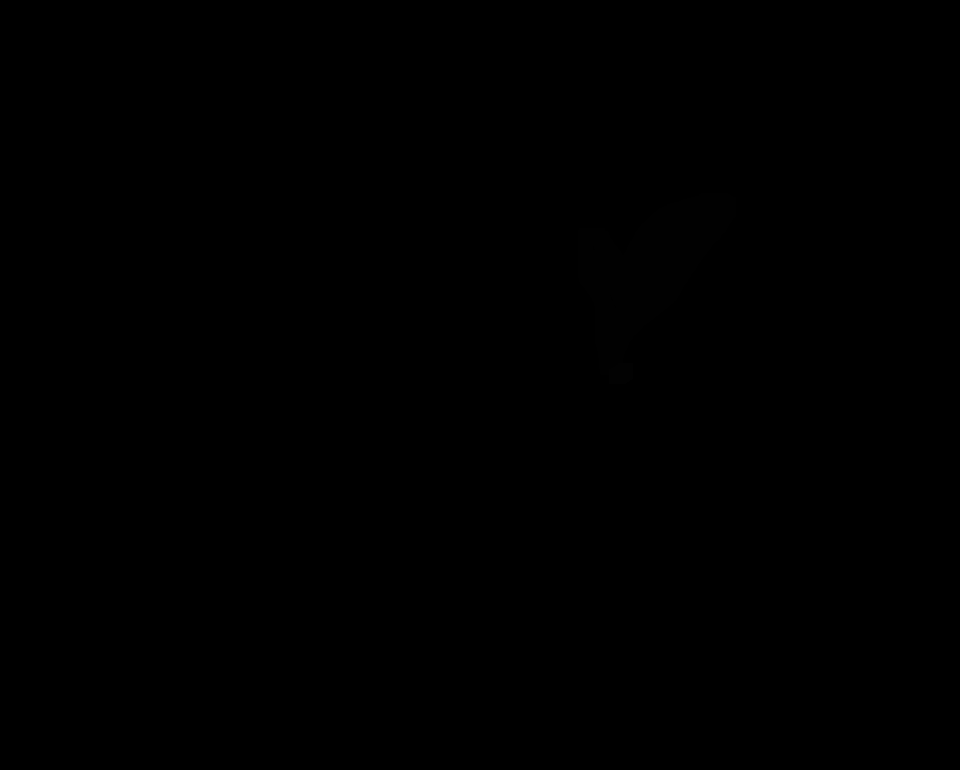

In [8]:
img = Image.open(lbl_names[0])
img.show()

In [9]:
get_y_fn = lambda x: path_label/f'label_{x.name}'
defaults.use_cuda = True

In [10]:
dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 4,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((385, 480))], # wide: 960/2 = 480, hight: 770/2 = 385
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


For fastai, the evaluation ratios include:  
```
__all__ = ['error_rate', 'accuracy', 'accuracy_thresh', 'dice', 'exp_rmspe', 'fbeta','FBeta', 'mse', 'mean_squared_error',
           'mae', 'mean_absolute_error', 'rmse', 'root_mean_squared_error', 'msle', 'mean_squared_logarithmic_error',
           'explained_variance', 'r2_score', 'top_k_accuracy', 'KappaScore', 'ConfusionMatrix', 'MatthewsCorreff',
           'Precision', 'Recall', 'R2Score', 'ExplainedVariance', 'ExpRMSPE', 'RMSE', 'Perplexity', 'AUROC', 'auc_roc_score', 
           'roc_curve', 'MultiLabelFbeta', 'foreground_acc']
```

In [11]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Background']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

metrics = acc_smoke

In [12]:
learn = unet_learner(dls, models.resnet34, metrics = metrics,
                    self_attention=True)

In [13]:
device = 'cuda'
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [14]:
# using the pretrained params --- go as a transfer learning
learn.load('/home/qiao/dev/giao/datasets/M300bounding/S_kaggle_wildfire/models/resized-f')

SuggestedLRs(valley=2.511886486900039e-05)

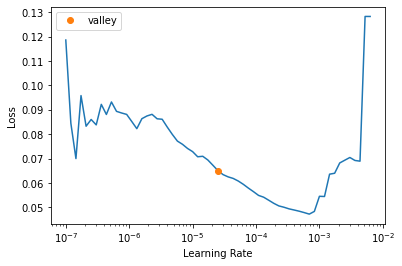

In [15]:
learn.lr_find()

In [16]:
lr = 2.51e-5
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,acc_smoke,time
0,0.044662,0.018214,0.993696,00:26
1,0.029390,0.013796,0.994487,00:23
2,0.022557,0.013008,0.994663,00:23
3,0.019152,0.012772,0.994753,00:23
4,0.016711,0.012732,0.994838,00:23


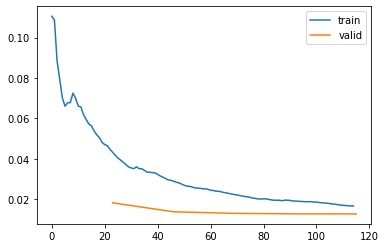

In [17]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [18]:
learn.save('pretrained20220613')
learn.load('pretrained20220613')

SuggestedLRs(valley=3.630780702224001e-05)

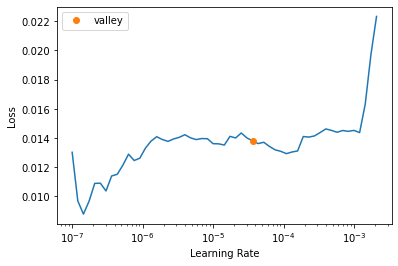

In [19]:
learn.unfreeze()
learn.lr_find()

In [20]:
lr_max = 1e-7

In [21]:
learn.fit_one_cycle(3, lr_max)

epoch,train_loss,valid_loss,acc_smoke,time
0,0.013562,0.012697,0.994827,00:24
1,0.013503,0.012662,0.994863,00:24
2,0.013433,0.012653,0.994878,00:24


/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


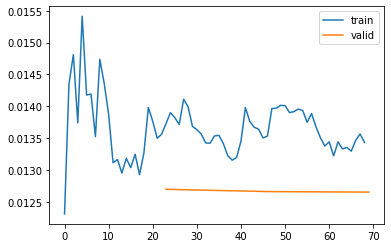

In [22]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

Path('/home/qiao/dev/giao/datasets/M300bounding/20220613/imgs/models/pretrained20220613-f.pth')

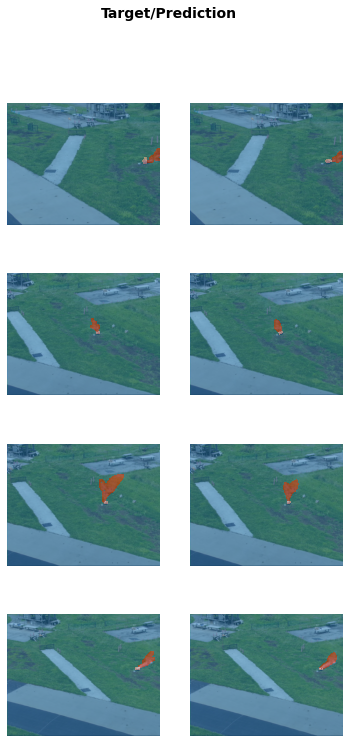

In [23]:
learn.show_results()
learn.save('pretrained20220613-f')

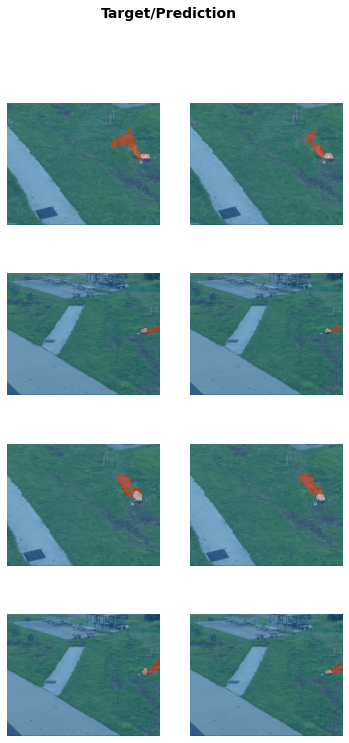

In [24]:
# learn.show_results()
learn.load('pretrained20220613-f')
learn.show_results()

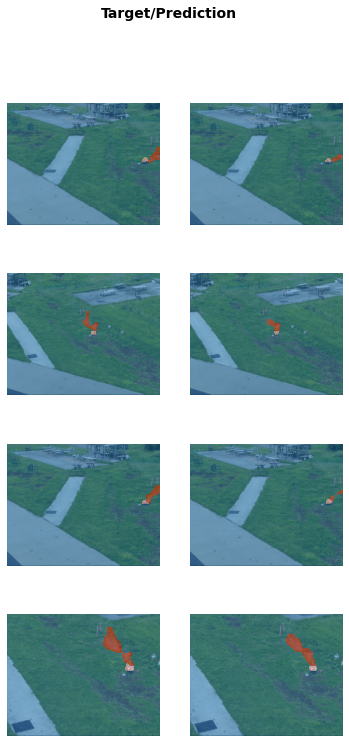

In [25]:
learn.show_results()

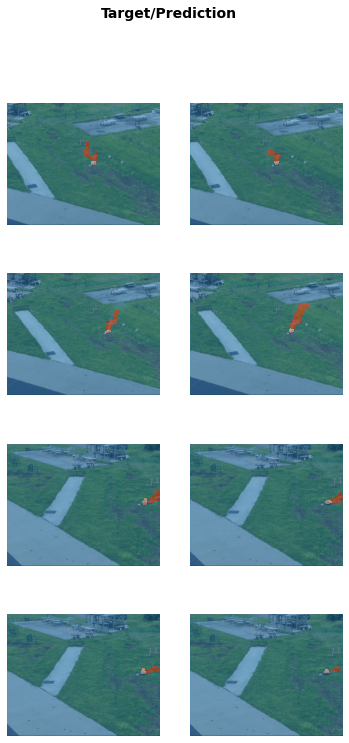

In [26]:
learn.show_results()

In [27]:
# learn.show_results()
# learn.save('alunet')

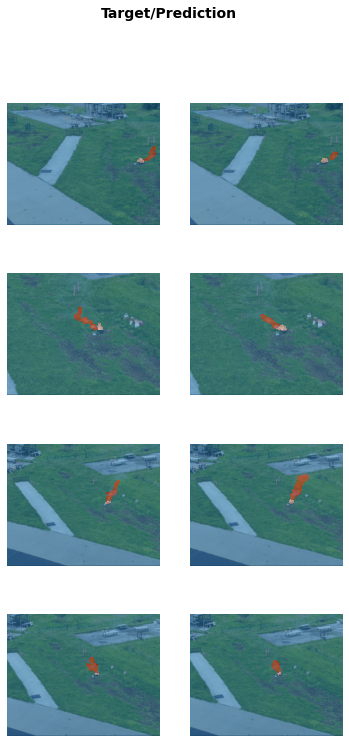

In [28]:
learn.show_results()

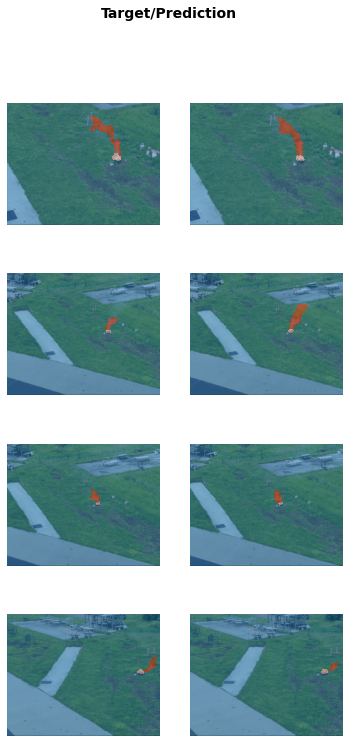

In [29]:
learn.show_results()

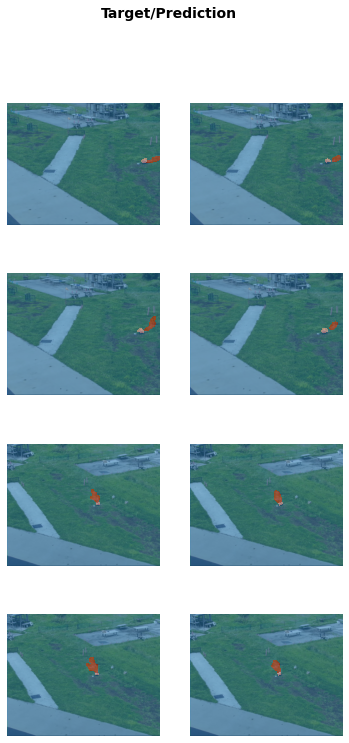

In [30]:
learn.show_results()

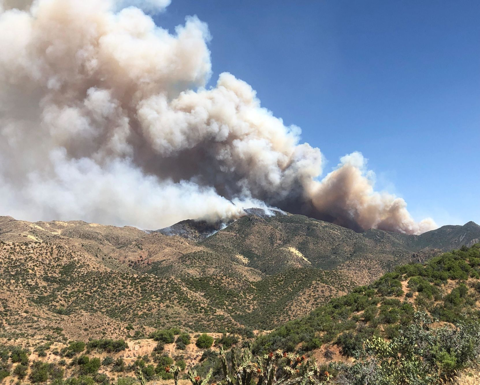

In [31]:
img = Image.open('/home/qiao/dev/giao/datasets/S_google_wildfire/004.png').resize((480, 385))
img.show()

In [32]:
img = PILImage(img)
print(img)

PILImage mode=RGB size=480x385


In [34]:
learn.load('pretrained20220613-f')
# learn.load('attunet')

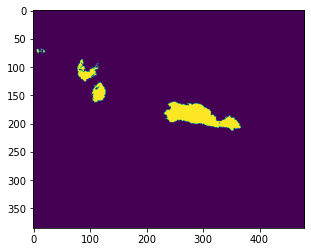

In [35]:
prediction_mask = learn.predict(img)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)

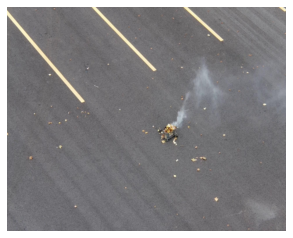

In [36]:
# one time test
import cv2
import numpy as np
from PIL import Image

img = cv2.imread('/home/qiao/dev/giao/datasets/bounding/images/DJI_20211017111122_0003_Z_MP4_1.png')

# You may need to convert the color.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pilimgimg = Image.fromarray(img).resize((480, 385))
img_pil = PILImage(im_pilimgimg)
img_pil.show()

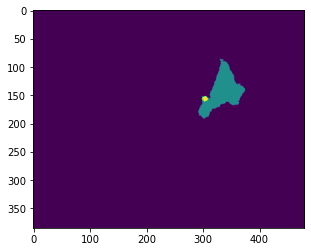

In [37]:
prediction_mask = learn.predict(img_pil)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)

## In this work, transfer learning idea is used and we used the pretrained parameters and slightly trained for more steps with the new dataset.
## The results are pretty well, accuracy even reached 99.487%